In [2]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_teokenize de nltk
from keras.utils import pad_sequences # se utilizará para padding
from matplotlib import pyplot as plt


2023-04-30 18:13:33.605108: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


En este caso trabaje con un dataset de noticias de Estados Unidos

In [3]:
df = pd.read_csv('datasets/raw_analyst_ratings.csv')

df.head()

,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [4]:
df = df.dropna().reset_index(drop=True)
df.isnull().sum()

Unnamed: 0    0
headline      0
url           0
publisher     0
date          0
stock         0
dtype: int64

Entrenaré un modelo usando los títulos de las noticias

In [5]:
headline_df = pd.DataFrame(df['headline'])

In [6]:
print("Cantidad de documentos:", headline_df.shape[0])

Cantidad de documentos: 1407328


In [7]:
# largo de la secuencia, incluye seq input + word output
train_len = 3

In [8]:
# Vistazo a las primeras filas
headline_df.iloc[:5,0]

0              Stocks That Hit 52-Week Highs On Friday
1           Stocks That Hit 52-Week Highs On Wednesday
2                        71 Biggest Movers From Friday
3         46 Stocks Moving In Friday's Mid-Day Session
4    B of A Securities Maintains Neutral on Agilent...
Name: headline, dtype: object

In [9]:
# Concatenamos todos los rows en un solo valor
corpus = headline_df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]

In [10]:
len(corpus)

104311875

In [11]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus[:1000000])
# Vistazo general de los primeros tokens
tokens[:5]

['stocks', 'that', 'hit', '52', 'week']

In [12]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 163273


In [13]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [14]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:4]

[['stocks', 'that', 'hit'],
 ['that', 'hit', '52'],
 ['hit', '52', 'week'],
 ['52', 'week', 'highs']]

In [15]:
# Proceso de tokenizacion
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:4]

[[8, 78, 140], [78, 140, 51], [140, 51, 37], [51, 37, 164]]

In [16]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 163270


In [17]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(163270, 2)
(163270,)


In [18]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

12955

In [19]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(163270, 12955)

In [20]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

2

In [21]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

12955

In [23]:
tokens=text_to_word_sequence(corpus[:250000])

text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

sequences = tok.texts_to_sequences(text_sequences)

arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] 

vocab_size = len(tok.word_counts)
vocab_size
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape
input_seq_len = x_data.shape[1] 
output_size = vocab_size
output_size

6031

In [27]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=7, input_length=input_seq_len))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='sigmoid'))

# Predicción de clasificación con softmax
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

2023-04-30 18:25:05.549329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-30 18:25:05.551501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-30 18:25:05.552892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 2, 7)              42224     
                                                                 
 lstm_10 (LSTM)              (None, 2, 64)             18432     
                                                                 
 dropout_7 (Dropout)         (None, 2, 64)             0         
                                                                 
 lstm_11 (LSTM)              (None, 2, 64)             33024     
                                                                 
 dropout_8 (Dropout)         (None, 2, 64)             0         
                                                                 
 lstm_12 (LSTM)              (None, 2, 128)            98816     
                                                                 
 dropout_9 (Dropout)         (None, 2, 128)           

Epoch 1/200


2023-04-30 18:25:15.186266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-30 18:25:15.188624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-30 18:25:15.190501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1015/1016 [============================>.] - ETA: 0s - loss: 7.2956 - accuracy: 0.0232

2023-04-30 18:25:43.357213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-30 18:25:43.359803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-30 18:25:43.361222: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1016/1016 [==============================] - 32s 22ms/step - loss: 7.2955 - accuracy: 0.0232 - val_loss: 7.2489 - val_accuracy: 0.0282
Epoch 2/200
1016/1016 [==============================] - 23s 23ms/step - loss: 6.8449 - accuracy: 0.0229 - val_loss: 7.3039 - val_accuracy: 0.0199
Epoch 3/200
1016/1016 [==============================] - 22s 21ms/step - loss: 6.7119 - accuracy: 0.0277 - val_loss: 7.3572 - val_accuracy: 0.0430
Epoch 4/200
1016/1016 [==============================] - 21s 21ms/step - loss: 6.5982 - accuracy: 0.0348 - val_loss: 7.4165 - val_accuracy: 0.0265
Epoch 5/200
1016/1016 [==============================] - 23s 22ms/step - loss: 6.4963 - accuracy: 0.0399 - val_loss: 7.4863 - val_accuracy: 0.0294
Epoch 6/200
1016/1016 [==============================] - 21s 21ms/step - loss: 6.3989 - accuracy: 0.0462 - val_loss: 7.5481 - val_accuracy: 0.0242
Epoch 7/200
1016/1016 [==============================] - 22s 21ms/step - loss: 6.3087 - accuracy: 0.0535 - val_loss: 7.6165 - val_

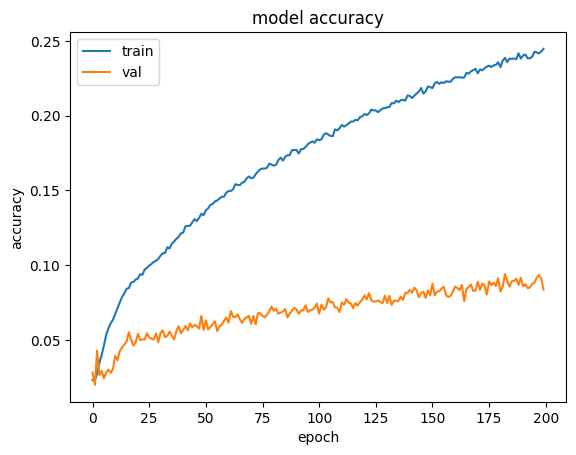

In [28]:
hist = model.fit(x_data, y_data, epochs=200, validation_split=0.2)

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Vamos a probar algunas sentencias

In [29]:
def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

In [30]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

Vemos algunas pruebas de que palabras sugiere ante determinadas frases

In [52]:
input_text='President barak'

generate_seq(model, tok, input_text, max_length=2, n_words=1)

1/1 [==============================] - 0s 93ms/step


'President barak announces'

In [32]:
input_text='President barak'

generate_seq(model, tok, input_text, max_length=2, n_words=5)

1/1 [==============================] - 0s 37ms/step


'President barak announces earnings buffett falls fund'

In [33]:
input_text='Minister say'

generate_seq(model, tok, input_text, max_length=2, n_words=5)

1/1 [==============================] - 0s 21ms/step


'Minister say toyota just on morgan stocks'

In [34]:
input_text='Covid was'

generate_seq(model, tok, input_text, max_length=2, n_words=5)

1/1 [==============================] - 0s 32ms/step


'Covid was europe the steel day in'

In [45]:
input_text='russia say'

generate_seq(model, tok, input_text, max_length=2, n_words=5)

1/1 [==============================] - 0s 80ms/step


'russia say law fund at of com'

In [47]:
input_text='russia china'

generate_seq(model, tok, input_text, max_length=2, n_words=5)

1/1 [==============================] - 0s 20ms/step


'russia china companies for close are for'

In [49]:
input_text='russia cuba'

generate_seq(model, tok, input_text, max_length=2, n_words=1)

1/1 [==============================] - 0s 40ms/step


'russia cuba europe'

In [51]:
input_text='russia ukraine'

generate_seq(model, tok, input_text, max_length=2, n_words=3)

1/1 [==============================] - 0s 171ms/step


'russia ukraine law upstream sectors'